# Demo

This jupyter notebook contains a demo / introduction to using our implementation of Stochastic Gradient Hamiltionian Monte Carlo (SGHMC) which is built on top of Pyro. There are a few caveats that you should understand before trying to use our implementation, so this idea of this document is to help you to use your implementation correctly.

This demo is very loosely inspired by: https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html#introduction-to-pyro

# Pyro

Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.

What this really means: Pyro provides a vast array of modelling and inference abilities, which are super-charged by PyTorch's automatic differentiation and GPU computing.

In [1]:
# imports
from matplotlib import pyplot as plt
import torch
import pyro
import numpy as np
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist
# our implementation of sghmc
from kernel.sghmc import SGHMC

# 1) Defining a model (aka, stochastic function)

In Pyro, a model is defined using a **"stochastic function"**.

A stochastic function is an arbitrary Python callable (function or method) that combines two ingredients:

- Deterministic Python code
- Primitive stochastic functions that call a random number generator.

## Primitive stochastic functions

These are basic elements which allow us to introduce stochasticity into our model, and essentially allow us to define different **distributions** in our model. The code below defines a normal distribution and samples from it:

## Adding data to the model

The key idea of SGHMC is that we subsample the observed data explained by the stochastic model and compute noisy gradient estimates which are used to simulate Hamiltonian dynamics in the same way as noise free HMC.   

### A Simple model:

This model is flexible it can take an arbitrary amount of data and condition on it to give us a posterior distribution.

In [2]:
def model(data):
    weight = pyro.sample("weight", dist.Normal(0, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 1.0), obs=data)

### Some data
Below we create some data for our model to condition on. Note that any data passed to the model to be subsampled **must** first be wrapped in a pytorch tensor.

In [3]:
data = torch.tensor([8.5992, 6.4611, 6.7287, 4.2451, 5.5909, 5.4184, 7.3571, 6.3754, 8.0597,
        8.7034])

# 2) Inference

## Inference using MCMC

Now, all we need to do is use an inference algorithm to estimate the posterior distribution of the unobserved random variables in our model (in this case, the weight of the object), given the observed data.

### Using SGHMC

Our data is positional argument 0 of our model, this is the default behaviour, although if we want to subsample more than one positional arguments then we need to specify the positions in the `subsample_positions` argument.

We can specify other things such as `batch_size`, `step_size`, `num_steps`, `with_friction`, `friction_term`, `friction_constant`, `obs_info_noise`, `compute_obs_info`, `do_mh_correction`, `do_step_size_adaptation`, `target_accept`

Note that the naive SGHMC algorithm does **not** use friction (but we can turn Metropolis Hastings correction on for this configuration and see the difference in performance)

Also note for the SGHMC algorithm we do **not** use MH correction since by using friction we get the desired invariant distribution. 

Its best not to set `do_step_size_adaptation = True` at the moment since the automatic step size adaptation is very unstable at the moment.

In [4]:
    """Stochastic Gradient Hamiltonian Monte Carlo kernel.
    
    Parameters
    ----------
    subsample_positions : list, default [0] / 1st positional argument only
        Specifies which positional arguments of the model to subsample during runtime
        
    batch_size : int, default=5
        The size of the minibatches to use

    step_size : int, default 0.1
        The size of a single step taken while simulating Hamiltonian dynamics

    num_steps : int, default 10
        The number of steps to simulate Hamiltonian dynamics
        
    with_friction : bool, default=True
        Use friction term when updating momentum

    resample_every_n : int, default 50
        When to resmaple to momentum (deafult is to resample momentum every 50 samples)

    friction_term : dict or None, default=None
        The friction term to use for the Langevin dynamics. This should be a 
        dictionary of square tensors, one for each of the model parameters,
        with the size of each matrix determined by the dimension of each
        parameter. The default is to use identity matrices for each
        parameter.

    obs_info_noise : bool, default=True
        Use the observed information to estimate the noise model

    compute_obs_info : string, default="every_sample", valid=["start", "every_sample", "every_step"]
        When to compute the observed information matrix to estimate B hat,
        - "start" once at the begining using the inital parameters
        - "every_sample" once at the start of every sampling procedure
        - "every_step" at every intehration step or when the parameters change

    do_mh_correction : bool, default False
        Compute the mh correction term using the whole dataset
        
    do_step_size_adaptation : bool, default True
        Do step size adaptation during warm up phase

    target_accept : float, deafult 0.8
        Target acceptance ratio for tuning the step size

    Limitations
    -----------

    - `friction_term` must be constant, and can't vary according to the values
    of the parameters.
    - `friction_term` yields a block matrix: friction is applied independently
    to each parameter. One parameter's values can't affect the friction on
    another.
    - The observed information is computed only once per sample, and is not
    updated while simulating the dynamics.
    """
    
# Instantiate the SGHMC kernel
sghmc_kernel = SGHMC(model, 
                     subsample_positions=[0],
                     batch_size=5, 
                     step_size=0.1, 
                     num_steps=5, 
                     resample_every_n=50,
                     with_friction=True, 
                     friction_term=None, 
                     friction_constant=1.0,
                     obs_info_noise=True,
                     compute_obs_info='every_step',
                     do_mh_correction=False,
                     do_step_size_adaptation=False,
                     target_accept=0.75)

# Use pyros MCMC sampling module
sghmc_mcmc = MCMC(sghmc_kernel, num_samples=1000)
# Pass the model parameters when we call run
sghmc_mcmc.run(data)
# Fetch samples from the sampler
sghmc_samples = sghmc_mcmc.get_samples()

Sample: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:44, 45.07it/s, step size=1.00e-01]


### Plotting the data
We can plot the empirical posterior distribution by plotting `sghmc_samples`

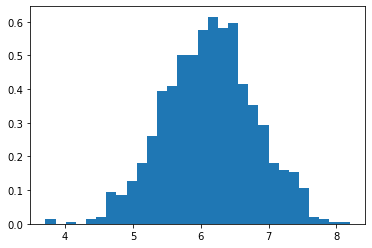

In [5]:
samples = sghmc_samples['weight'].numpy()

plt.hist(samples, density=True, bins=30)  # density=False would make counts
plt.show()

### Using SGLD

Again, our data is positional argument 0 of our model, this is the default behaviour, although if we want to subsample more than one positional arguments then we need to specify the positions in the `subsample_positions` argument.

We can specify other things such as `batch_size`, `step_size`, `num_steps`,`obs_info_noise`, `compute_obs_info`

In [7]:
from kernel.sgld import SGLD

sgld_kernel = SGLD(model, 
                   subsample_positions=[0], 
                   batch_size=5, 
                   step_size=0.1, 
                   num_steps=5, 
                   obs_info_noise=True, 
                   compute_obs_info='every_sample')

sgld_mcmc = MCMC(sgld_kernel, num_samples=1000)
sgld_mcmc.run(data)
sgld_samples = sgld_mcmc.get_samples()

Sample: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:20, 98.17it/s, step size=1.00e-01]


### Plotting the data
We can plot the empirical posterior distribution output by SGLD by plotting `sgld_samples` and compare the two sampling algorithms

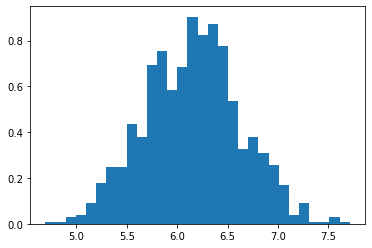

In [8]:
samples = sgld_samples['weight'].numpy()

plt.hist(samples, density=True, bins=30)  # density=False would make counts
plt.show()

### Using SGD

Our library has an implementation of Stochastic Gradient Descent which unintuitively subclasses pyros MCMCKernel (simply for convenience). Note that the samples drawn from SGD are not from the posterior since SGD is an optimization algorithm, so take extra care when dealing with the samples.

As before our data is positional argument 0 of our model, this is the default behaviour, although if we want to subsample more than one positional arguments then we need to specify the positions in the `subsample_positions` argument.

We can specify other things such as `batch_size`, `step_size`, `num_steps`

In [9]:
from kernel.sgd import SGD

sgd_kernel = SGD(model, 
                 subsample_positions=[0], 
                 batch_size=5, 
                 step_size=0.001, 
                 weight_decay=0.1,
                 with_momentum=True,
                 alpha=0.25)

sgd_mcmc = MCMC(sgd_kernel, num_samples=1000, warmup_steps=0)
sgd_mcmc.run(data)
sgd_samples = sgd_mcmc.get_samples()

Sample: 100%|███████████████████████████████████████████████████| 1000/1000 [00:02, 421.82it/s, learning rate=1.00e-03]


### Plotting the data
We can plot the sample space that SGD traversed by plotting `sgd_samples`

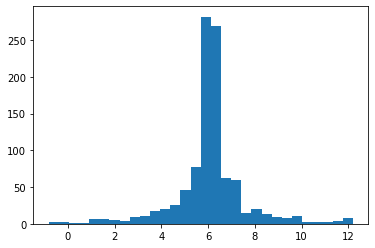

In [10]:
import numpy as np
samples = sgd_samples['weight'].numpy()

plt.hist(samples, bins=30)  # density=False would make counts
plt.show()

## More flexible models

Our implementation of SGHMC is flexible enough to allow you to specify arbitrary positional and keyword arguments. Although you can **only** subsample positional arguments!!! This shouldn't be too restrictive of a requirement, but below we give good some examples of how to use our implementation of SGHMC properly and some bad examples.

We won't run any inference but if you're interested but the following examples will be based on coin flipping using a beta prior and binomial likelihood. See `example.ipynb` and play around with it to convince yourself the following examples will work or not. 

### Model with arbitrary key word arguments

In this example we supply our model with hyper-priors for the beta distribution by using key word arguments. The default is `alpha0=1.` and `beta0=1.` which is just the uniform distribution on the unit interval.

In [ ]:
def model(data, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f = pyro.sample("coin", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs", dist.Bernoulli(f), obs=dats)

If we want to run inference using our implementation of SGHMC we needn't change much we just need to specify `alpha0` and `beta0` by passing it to the `.run()` method.

In [ ]:
# Instantiate the SGHMC kernel
sghmc_kernel = SGHMC(model, 
                     subsample_positions=[0],
                     batch_size=5, 
                     step_size=0.1, 
                     num_steps=4, 
                     with_friction=True, 
                     friction_term=None, 
                     friction_constant=1.0,
                     obs_info_noise=False,
                     do_mh_correction=False,
                     do_step_size_adaptation=False,
                     target_accept=0.75)

# Use pyros MCMC sampling module
sghmc_mcmc = MCMC(sghmc_kernel, num_samples=1000)
# Pass the model parameters when we call run
# Here we specify a stronger prior over the latent fairness of the coinflip
sghmc_mcmc.run(data, alpha0=10., beta0=10.) # <------------------------
# Alternatively we can specify neither alpha0 or beta0 and use their default values
sghmc_mcmc.run(data)
# Fetch samples from the sampler
sghmc_samples = sghmc_mcmc.get_samples()

### Model with no positional arguments

The following is a bad example where the observed data is passed as a key word argument, this will not be compatible with our implementation of SGHMC and you may get some undefined behaviour. So please pass any observed data that you wish to subsample as positional arguments.

In [ ]:
def model(data=torch.zeros(10)):
    alpha0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)
    
    f = pyro.sample("coin", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs", dist.Bernoulli(f), obs=dats)

For example do this instead,

In [ ]:
data = torch.zeros(10)

def model(data):
    alpha0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)
    
    f = pyro.sample("coin", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs", dist.Bernoulli(f), obs=data)

### Model with multiple positional arguments to subsample

The below model specifies the outcome of two independent coin flips, we may wish to pass observation data as two seperate positional arguments. Our implementation of SGHMC is flexible enough to handle this use case we just need to set `subsample_positions` appropriately

In [ ]:
x1 = torch.ones(10)
x1[0:6] = torch.zeros(6)

x2 = torch.ones(10)
x2[0:2] = torch.zeros(2)

def model(x1, x2, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f1 = pyro.sample("coin1", dist.Beta(alpha0, beta0))
    f2 = pyro.sample("coin2", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs1", dist.Bernoulli(f1), obs=x1), pyro.sample("obs2", dist.Bernoulli(f2), obs=x2)

We want to subsample both `x1` and `x2` and so we must set `subsample_positions=[0, 1]` given that `x1` and `x2` are positional argument `0` and `1` respectively. Otherwise, we could get some strange behaviour. 

In [ ]:
# Instantiate the SGHMC kernel
sghmc_kernel = SGHMC(model, 
                     subsample_positions=[0],
                     batch_size=5, 
                     step_size=0.1, 
                     num_steps=4, 
                     with_friction=True, 
                     friction_term=None, 
                     friction_constant=1.0,
                     obs_info_noise=False,
                     do_mh_correction=False,
                     do_step_size_adaptation=False,
                     target_accept=0.75)

# Use pyros MCMC sampling module
sghmc_mcmc = MCMC(sghmc_kernel, num_samples=1000)
# Pass the model parameters when we call run
sghmc_mcmc.run(x1, x2)
# Fetch samples from the sampler
sghmc_samples = sghmc_mcmc.get_samples()

Note that it is **essential** that `x1` and `x2` be the same size, it doesn't make sense that during our trial of two independent coin flips we forget to flip one of the coins. It is always the case that when we condition on more than one positional argument the supplied data must have the same length in the first dimension. 

If you need more flexibility just pack the data into tensors and make sure the first dimensions are of equal size and unpack the data in the model. Although models that require this sort of flexbility can probably be refactored anyway to obey these restrictions with no semantic changes to the program.

### Silly example

This silly example is just poor practice but it shows the flexbility of our SGHMC implementation. For example suppose `alpha0` is a positional argument and `beta0` is a key word argument.

In [11]:
def model(data, alpha0, beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f = pyro.sample("coin", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs", dist.Bernoulli(f), obs=dats)

Now when we run SGHMC we have to specify `alpha0` but we could just leave `beta0` as its default value. 

In [ ]:
# Instantiate the SGHMC kernel
sghmc_kernel = SGHMC(model, 
                     subsample_positions=[0],
                     batch_size=5, 
                     step_size=0.1, 
                     num_steps=4, 
                     with_friction=True, 
                     friction_term=None, 
                     friction_constant=1.0,
                     obs_info_noise=False,
                     do_mh_correction=False,
                     do_step_size_adaptation=False,
                     target_accept=0.75)

# Use pyros MCMC sampling module
sghmc_mcmc = MCMC(sghmc_kernel, num_samples=1000)
# Pass the model parameters when we call run
# alpha0 is positional argument 1 and we must specify it or we will get an error
sghmc_mcmc.run(data, 1.)
# We can specify beta0 too if we want but since it is a kwarg it is optional
sghmc_mcmc.run(data, 10., beta0=10.)
# Fetch samples from the sampler
sghmc_samples = sghmc_mcmc.get_samples()

The following instantiation of `sghmc_kernel` would be **wrong** since we don't want to subsample alpha0!!!

In [ ]:
# Instantiate the SGHMC kernel
sghmc_kernel = SGHMC(model, subsample_positions=[0, 1] ,batch_size=5, step_size=0.1, num_steps=4, with_friction=True, do_mh_correction=False)
# This is worng since subsample_positions=[0, 1] which says we want to subsample positional argument 1, namely alpha0